In [26]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from datetime import datetime
from astropy.io import fits
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from astropy.table import Table

np.set_printoptions(precision=4)

### Problem 1. Orbit integration with solve_ivp and odeint

a) Calcultate the orbit of your favorite terrestrial planet (Mercury, Venus, Earth, and Mars), using $solve$_$ivp$ and $odeint$.  Plot both results on the same plot.  Label clearly.  Do both methods work equally well?

b)  Calculate the orbit of a circular orbit at 1 AU, using the same $dt, nsteps$, etc..  I provide the initial conditions $u_0$.  On the same plot, plot this circular orbit with that of your planet.

In [27]:
# Orbit integration with solve_ivp and odeint

GM = 1.327124400e20
AU = 149597870700.
SecPerYear = 31557600.

def getInitState(id, start, end, ephem_step_size, origin):
    
# Setup HORIZONS query for the desired body by id
    vectors = Horizons(id=id, epochs={'start' : start.strftime("%Y-%m-%d %H:%M"),
            'stop' : end.strftime("%Y-%m-%d %H:%M"), 'step' : ephem_step_size}, location=origin).vectors() 
    posvec = np.array([np.double(vectors[xi]) for xi in ['x', 'y', 'z']])  
    vvec = np.array([np.double(vectors[xi]) for xi in ['vx', 'vy', 'vz']])    
# Note: posvec is x,y,z in AU
# vvec is vx, vy, vz in AU/day 
# need to convert to m and m/s
    return posvec*AU, vvec*AU/86400 #convert to m/s, 86400 seconds in a day

# Write f_solve to be used with solve_ivp.
# If I were to do it for only x and y I would write:

def f_solve(t,u):   #for 2D only
    x,y,vx,vy = u
    rvector = np.array([x, y])
    r = np.linalg.norm(rvector)
    Fgrav = GM/r**3
    return np.array([vx, vy, -Fgrav*x, -Fgrav*y])

# rewrite f_solve for x, y, and z.  This is what you will use for solve_ivp.


PLANET_IDS = {
'1': 'Mercury',
'2': 'Venus',
'3': 'Earth',
'4': 'Mars'}

planetID = 1
id = planetID
start = datetime(2022,3,24)
end = datetime(2023,3,24)
ephem_step_size='2h'
origin = '@ssb'

rJPL,vJPL = getInitState(planetID, start, end, ephem_step_size, origin)
            
dt = 7200.  # 2 hrs
nsteps = 4380 #4393 gave an error, rJPL is actually of length 4380

rJPL, vJPL = getInitState(planetID, start, end, ephem_step_size, origin) 
t_eval = np.linspace(0, nsteps * dt, nsteps + 1)
u0 = np.concatenate((np.array(rJPL)[:, 0], np.array(vJPL)[:, 0]))

def f_solve_3d_IVP(t, u):
    x, y, z, vx, vy, vz = u
    rvect = np.array([x, y, z])
    r = np.linalg.norm(rvect)
    gravity = GM / (r ** 3)
    return np.array([vx, vy, vz, -gravity * x, -gravity * y, -gravity * z])

def f_solve_3d_ODE(u, t):
    x, y, z, vx, vy, vz = u
    rvect = np.array([x, y, z])
    r = np.linalg.norm(rvect)
    gravity = GM / (r ** 3)
    return np.array([vx, vy, vz, -gravity * x, -gravity * y, -gravity * z])

solIVP = solve_ivp(f_solve_3d_IVP, (t_eval[0], t_eval[-1]), u0, t_eval=t_eval)
IVP = solIVP.y
solODE = odeint(f_solve_3d_ODE, u0, t_eval)
ODE = solODE[:, 0]

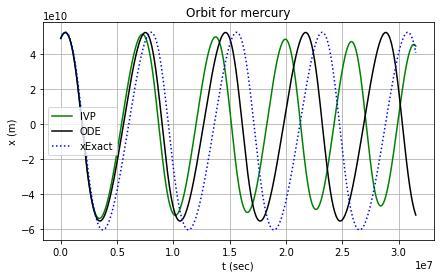

In [28]:
fig,ax = plt.subplots(figsize = (7, 4))
ax.plot(t_eval, IVP[0, :], 'g', label='IVP')
ax.plot(t_eval, ODE, 'k', label='ODE')
ax.plot(t_eval, rJPL[0], 'b', label='xExact', linestyle = 'dotted')
ax.set_xlabel('t (sec)')
ax.set_ylabel('x (m)')
ax.set_title('Orbit for mercury')
ax.grid(True)
ax.legend()

# ax[1].plot(t, x_IVP - xExact, 'g-o', label='IVP')
# ax[1].plot(t, x_ODE - xExact, 'b-o', label='ODE')
# ax[1].set_xlabel('t (sec)')
# ax[1].set_ylabel('Error (m)')
# ax[1].grid(True)
# ax[1].legend()

# fig.tight_layout()

# ODE seems to work a bit better than IVP, though they both falter partway through the graph.

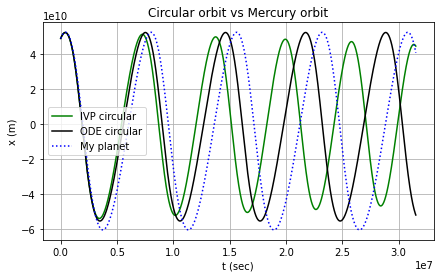

In [29]:
# Part b) initial conditions for circular orbit at 1 AU

r0 = np.array([1.*AU,0.,0.])
v_circ = math.sqrt(GM/np.linalg.norm(r0))
v0 = np.array([0.,v_circ,0.])
u0AU = np.concatenate((r0, v0))

solIVPAU = solve_ivp(f_solve_3d_IVP, (t_eval[0], t_eval[-1]), u0AU, t_eval=t_eval)
IVPAU = solIVP.y
solODEAU = odeint(f_solve_3d_ODE, u0AU, t_eval)
ODEAU = solODE[:, 0]

fig,ax = plt.subplots(figsize = (7, 4))
ax.plot(t_eval, IVPAU[0, :], 'g', label='IVP circular')
ax.plot(t_eval, ODEAU, 'k', label='ODE circular')
ax.plot(t_eval, rJPL[0], 'b', label='My planet', linestyle = 'dotted')
ax.set_xlabel('t (sec)')
ax.set_ylabel('x (m)')
ax.set_title('Circular orbit vs Mercury orbit')
ax.grid(True)
ax.legend()


### CCD Images

In [30]:
# load image
test = fits.getdata('/Users/Thinkpad/AST_51/Homework/HW10Data/RawR/ALCi250227.fits')

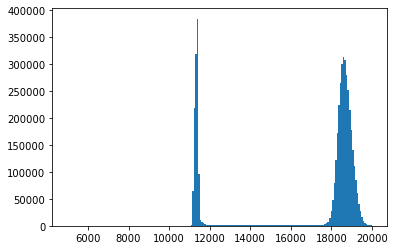

In [31]:
#simple way to look at fits image
# first do a histogram of pixel values so we can set the image stretch
# you will also need if using DS9 anyway

histogram = plt.hist(test.flatten(), range=[5e3,2e4],bins='auto')

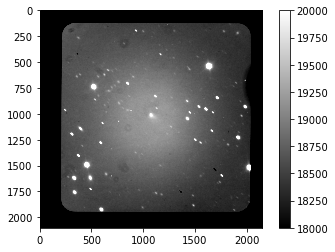

In [32]:
# use imshow

plt.imshow(test, cmap='gray',vmin=18000,vmax=20000)
plt.colorbar()

# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

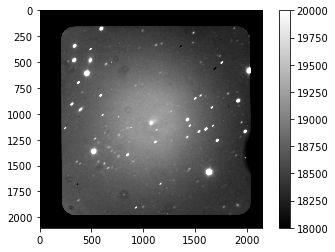

In [33]:
# For some reason imshow shows the image upside down compared to DS9, so we turn it right side up.

plt.imshow(test[::-1,:], cmap='gray',vmin=18000,vmax=20000)
plt.colorbar()

In [34]:
# Make master bias from indiviual biases
# bias = ALCi250258 - ALCi250268

os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/Biases')

# how to make an image list

image_list = [f'ALCi{i}.fits' for i in range(250258, 250269)]
print(image_list)

imageArray = [fits.getdata(image) for image in image_list]  #this is a list
imageArray = np.array(imageArray)                           # turn list into a 3D array
print(imageArray.shape)

imageArray = imageArray[:,150:1940,210:2020]                #chop off overscan region

bias = np.mean(imageArray, axis=0)  # axis = 0 means along stack axis

bias.shape

['ALCi250258.fits', 'ALCi250259.fits', 'ALCi250260.fits', 'ALCi250261.fits', 'ALCi250262.fits', 'ALCi250263.fits', 'ALCi250264.fits', 'ALCi250265.fits', 'ALCi250266.fits', 'ALCi250267.fits', 'ALCi250268.fits']
(11, 2102, 2148)


(1790, 1810)

### Problem 2

a) Examine a single bias image  (specify which bias frame), calculate the mean and standard deviation, and start filling out the table below.  
b) Calculate the mean and standard deviation of master bias.  
c) On the same plot, plot the row $y = 1000$ from an individual bias and from the master bias. Do the 2 lines look the same? Why or why not?  
d) If we average 10 individual zeros together, what do we expect the noise level to do?   

In [35]:
#Examining bias frame ALCi250258.fits

os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/Biases')

# how to make an image list

image_list = [f'ALCi{i}.fits' for i in range(250258, 250269)]
print(image_list)

imageArray = [fits.getdata(image) for image in image_list]  #this is a list
imageArray = np.array(imageArray)                           # turn list into a 3D array
print(imageArray.shape)

imageArray = imageArray[:,150:1940,210:2020]                #chop off overscan region

bias = np.median(imageArray, axis=0)  # axis = 0 means along stack axis

imageMean = np.mean(imageArray[0])
print('image bias mean', imageMean)
imageStdev = np.std(imageArray[0])
print('image bias stdev', imageStdev)
masterMean = np.mean(bias)
print('master bias mean', masterMean)
masterStdev = np.std(bias)
print('master bias stdev', masterStdev)

['ALCi250258.fits', 'ALCi250259.fits', 'ALCi250260.fits', 'ALCi250261.fits', 'ALCi250262.fits', 'ALCi250263.fits', 'ALCi250264.fits', 'ALCi250265.fits', 'ALCi250266.fits', 'ALCi250267.fits', 'ALCi250268.fits']
(11, 2102, 2148)
image bias mean 11200.86814778234
image bias stdev 36.01867531209693
master bias mean 11170.9032374456
master bias stdev 14.764419052354455


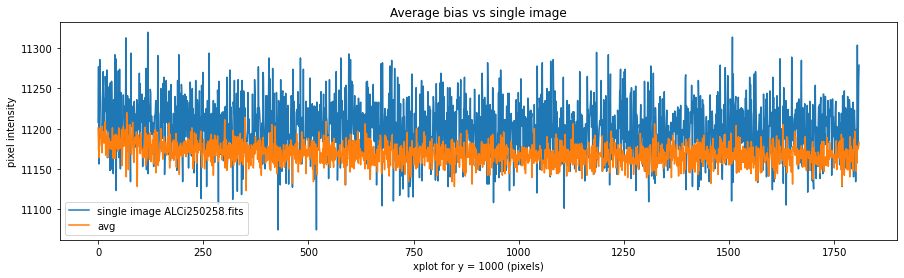

In [36]:
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(range(0, 1810), imageArray[0, 1000, :], label='single image ALCi250258.fits')
ax.plot(range(0, 1810), bias[1000, :], label = 'avg')
ax.set_xlabel('xplot for y = 1000 (pixels)')
ax.set_ylabel('pixel intensity')
ax.set_title('Average bias vs single image')
ax.legend()

c) The lines do not look the same because the average bias is the average of all biases. One example is likely to have more noise apparent than an average.

d) Noise should decrease because we are taking the average of many pictures.

### Problem 3  
a) Examine an R flat field (specify which one).  On a single plot, plot the rows at y = 350, 1000, 1600.  How much do their means vary?  
b) Find various artifacts: defects on CCD, dust spots, etc.   What is the sensitivity difference between these regions and the surrounding parts of the detector?  
c) Create Master Flat for each filter by taking the mean of the flats.  Finish filling out table.  

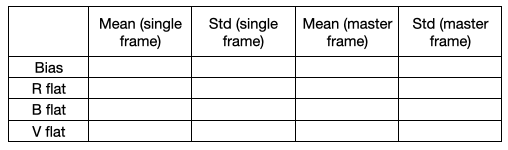

3
(3, 1790, 1810)


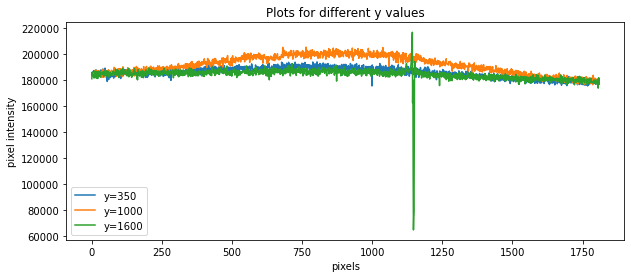

In [37]:
# subtract bias from each R flat, then average them (along the stack axis) to make final 
# Rflat

os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/RFlats')

image_listR = [f'ALCi{i}.fits' for i in range(250039, 250042)]
imageArrayR = [fits.getdata(image) for image in image_listR]    # read in data
imageArrayR = np.array(imageArrayR)
print(len(imageArrayR))

imageArrayR = imageArrayR[:,150:1940,210:2020]  #chop off overscan region
print(imageArrayR.shape)

for i in np.arange(len(imageArrayR)):
    imageArrayR[i,:,:] = imageArrayR[i,:,:] - bias  #subtract bias BEFORE calculating mean

master_Rflat = np.median(imageArrayR, axis=0)

#examining ALCi250039.fits
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(range(0, 1810), imageArrayR[0, 350, :], label='y=350')
ax.plot(range(0, 1810), imageArrayR[0, 1000, :], label = 'y=1000')
ax.plot(range(0, 1810), imageArrayR[0, 1600, :], label = 'y=1600')
ax.set_xlabel('pixels')
ax.set_ylabel('pixel intensity')
ax.set_title('Plots for different y values')
ax.legend()

In [38]:
print('mean for y=350:', np.mean(imageArrayR[0, 350, :]))
print('mean for y=1000:', np.mean(imageArrayR[0, 1000, :]))
print('mean for y=1600:', np.mean(imageArrayR[0, 1600, :]))
print('percent difference between y=1000 and y=1600', (np.mean(imageArrayR[0, 1000, :]) - np.mean(imageArrayR[0, 1600, :])) * 100 / np.mean(imageArrayR[0, 1000, :]))

mean for y=350: 185753.31546961327
mean for y=1000: 191912.01104972375
mean for y=1600: 184296.09392265193
percent difference between y=1000 and y=1600 3.9684421446131184


# Means do not vary by much. Maximum % difference is 3.9% as shown above

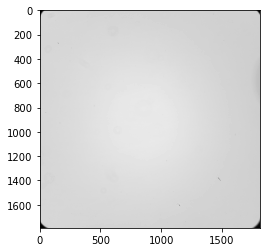

In [39]:
#3b finding dust spots

plt.imshow(imageArrayR[0], cmap='gray')
plt.show()

# This image does not really give any insight into  defects on CCD or dust spots. However, after changing to a power scale, we can clearly see multiple defects on CCD or dust spots:

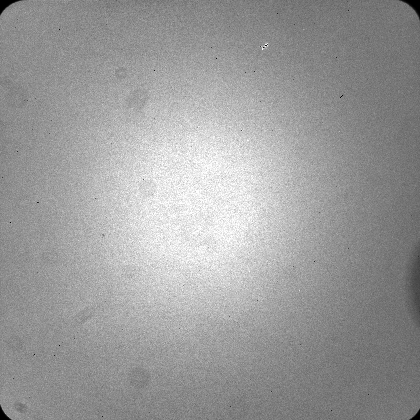

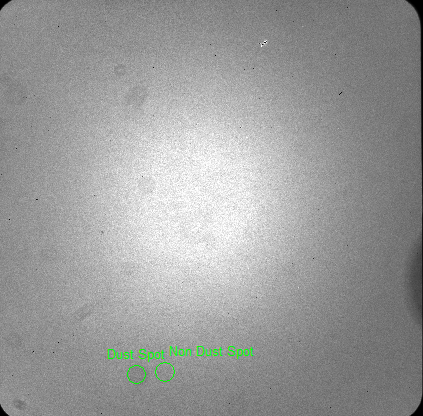

Statistics for dust spot:

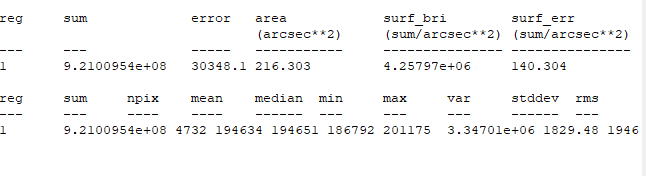

Statistics for non dust spot:

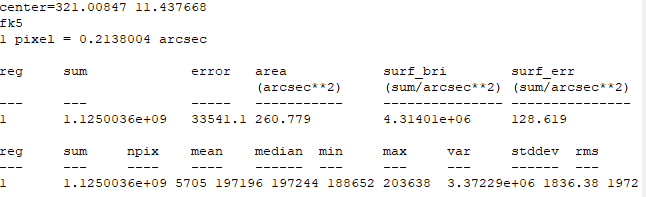

# As we can see, the mean of the dust spot is a bit smaller than the mean of the non-dust spot. The sensitivity difference is around 197196 - 194634 = 2562 for this one spot.

In [40]:
#3c - finish filling out table

In [41]:
imageMeanR = np.mean(imageArrayR[0])
print('R single image mean', imageMeanR)
imageStdevR = np.std(imageArrayR[0])
print('R single image stdev', imageStdevR)
masterMeanR = np.mean(master_Rflat)
print('R master mean', masterMeanR)
masterStdevR = np.std(master_Rflat)
print('R master stdev', masterStdevR)

R single image mean 187272.55613784376
R single image stdev 8671.74924688263
R master mean 198872.35542393284
R master stdev 9200.972758662338


In [42]:
#examining Bflat: ALCi250031.fits

os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/BFlats')

image_listB = [f'ALCi{i}.fits' for i in range(250031, 250034)]
imageArrayB = [fits.getdata(image) for image in image_listB]    # read in data
imageArrayB = np.array(imageArrayB)
print(len(imageArrayB))

imageArrayB = imageArrayB[:,150:1940,210:2020]  #chop off overscan region
print(imageArrayB.shape)

for i in np.arange(len(imageArrayB)):
    imageArrayB[i,:,:] = imageArrayB[i,:,:] - bias  #subtract bias BEFORE calculating mean

master_Bflat = np.median(imageArrayB, axis=0)


imageMeanB = np.mean(imageArrayB[0])
print('B single image mean', imageMeanB)
imageStdevB = np.std(imageArrayB[0])
print('B single image stdev', imageStdevB)
masterMeanB = np.mean(master_Bflat)
print('B master mean', masterMeanB)
masterStdevB = np.std(master_Bflat)
print('B master stdev', masterStdevB)

3
(3, 1790, 1810)
B single image mean 267688.0974770826
B single image stdev 11152.74418313643
B master mean 233327.37480477794
B master stdev 9731.597890949728


In [43]:
#examining ALCi250035.fits
os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/VFlats')

image_listV = [f'ALCi{i}.fits' for i in range(250035, 250038)]
imageArrayV = [fits.getdata(image) for image in image_listV]    # read in data
imageArrayV = np.array(imageArrayV)
print(len(imageArrayV))

imageArrayV = imageArrayV[:,150:1940,210:2020]  #chop off overscan region
print(imageArrayV.shape)

for i in np.arange(len(imageArrayV)):
    imageArrayV[i,:,:] = imageArrayV[i,:,:] - bias  #subtract bias BEFORE calculating mean

master_Vflat = np.median(imageArrayV, axis=0)

imageMeanV = np.mean(imageArrayV[0])
print('V single image mean', imageMeanV)
imageStdevV = np.std(imageArrayV[0])
print('V single image stdev', imageStdevV)
masterMeanV = np.mean(master_Vflat)
print('V master mean', masterMeanV)
masterStdevV = np.std(master_Vflat)
print('V master stdev', masterStdevV)

3
(3, 1790, 1810)
V single image mean 188078.37045556962
V single image stdev 8577.282006547333
V master mean 198248.43443840859
V master stdev 9019.91275644027


# Table with all statistics






| Frame Type | Mean (Single Frame) | Std (Single Frame) | Mean (Master Frame) | Std (Master Frame) |
|------------|---------------------|--------------------|----------------------|---------------------|
| Bias       |  11200.86814778234  |  36.01867531209693 | 11171.286672624568   |13.506215301323593   |
| R Flat     |  187271.71817679558 |  8671.766481470855 | 1.0171349741788633   | 0.003566046804128917|
| B Flat     | 267687.25951603445  |  11152.740573255624| 0.99450959509067     | 0.003946627471935204|
| V Flat     |  188077.53249452144 |   8577.268990123139| 0.8448886858164855   | 0.016797388597778563|


### Problem 4

In [44]:
# Flatten V
#  processed_image = (raw_image - FinalBias)/flat_final  
os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/RawV')

image_listRawV = [f'ALCi{i}.fits' for i in range(250221, 250224)]
imageArrayRawV = [fits.getdata(image) for image in image_listRawV]    # read in data
imageArrayRawV = np.array(imageArrayRawV)
imageArrayRawV = imageArrayRawV[:,150:1940,210:2020]  #chop off overscan region

for i in np.arange(len(imageArrayRawV)):
    imageArrayV[i,:,:] = (imageArrayV[i,:,:] - bias) / master_Vflat

# Flatten R
#  processed_image = (raw_image - FinalBias)/flat_final  
os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/RawR')

image_listRawR = [f'ALCi{i}.fits' for i in range(250227, 250231)]
imageArrayRawR = [fits.getdata(image) for image in image_listRawR]    # read in data
imageArrayRawR = np.array(imageArrayRawR)

imageArrayRawR = imageArrayRawR[:,150:1940,210:2020]  #chop off overscan region

for i in np.arange(len(imageArrayRawR)):
    imageArrayRawR[i,:,:] = (imageArrayRawR[i,:,:] - bias) / master_Rflat


# Flatten B
#  processed_image = (raw_image - FinalBias)/flat_final  
os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/RawB')

image_listRawB = [f'ALCi{i}.fits' for i in range(250218, 250221)]
imageArrayRawB = [fits.getdata(image) for image in image_listRawB]    # read in data
imageArrayRawB = np.array(imageArrayRawB)

imageArrayRawB = imageArrayRawB[:,150:1940,210:2020]  #chop off overscan region

for i in np.arange(len(imageArrayRawB)):
    imageArrayRawB[i,:,:] = (imageArrayRawB[i,:,:] - bias) / master_Bflat

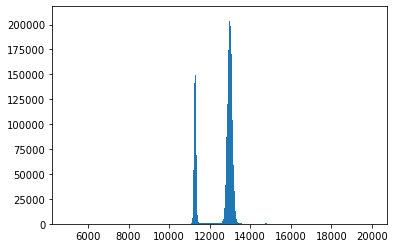

In [45]:
# get unflattened image for comparison
unflattened = fits.getdata('ALCi250218.fits')
histogram = plt.hist(unflattened.flatten(), range=[5e3,2e4],bins='auto')

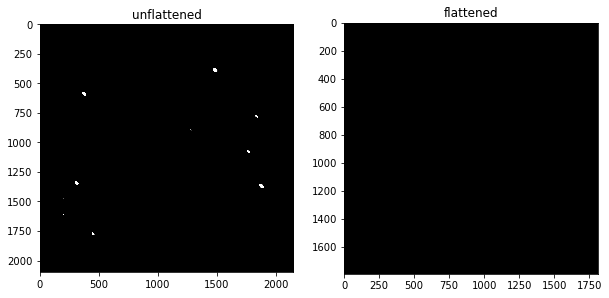

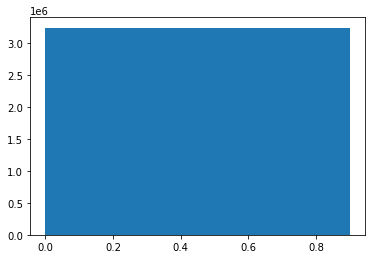

In [59]:
# plot unflattened image next to flattened image:

#ALCi250218.fits
unflattened = fits.getdata('/Users/Thinkpad/AST_51/Homework/HW10Data/RawB/ALCi250218.fits')
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(unflattened, cmap='gray', vmin=18000,vmax=20000)
axs[0].set_title('unflattened')
axs[1].imshow(imageArrayRawB[0], cmap='gray', vmin=0,vmax=1)
axs[1].set_title('flattened')
plt.show()


Text(0.5, 1.0, 'flattened')

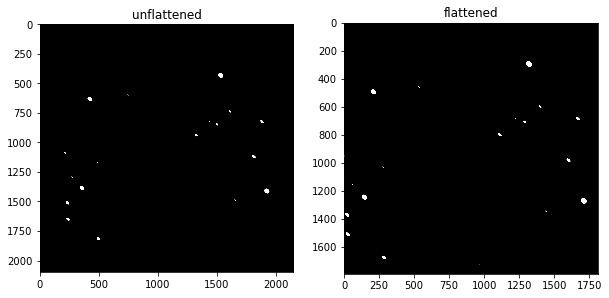

In [47]:
#ALCi250221.fits

os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/RawV')
unflattened = fits.getdata('ALCi250221.fits')
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(unflattened, cmap='gray', vmin=18000,vmax=20000)
axs[0].set_title('unflattened')
axs[1].imshow(imageArrayRawV[0], cmap='gray', vmin=18000,vmax=20000)
axs[1].set_title('flattened')

Text(0.5, 1.0, 'flattened')

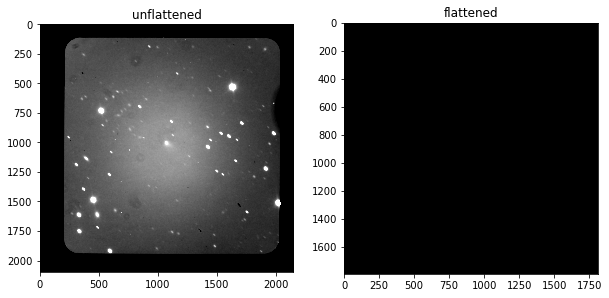

In [48]:
#ALCi250227.fits

os.chdir('/Users/Thinkpad/AST_51/Homework/HW10Data/RawR')
unflattened = fits.getdata('ALCi250227.fits')
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(unflattened, cmap='gray', vmin=18000,vmax=20000)
axs[0].set_title('unflattened')
axs[1].imshow(imageArrayRawR[0], cmap='gray', vmin=24500,vmax=26000)
axs[1].set_title('flattened')